# Clustering (15 points):
Each item is worth 3 points.

For each question that asks to implement a function, implement it in the top cell where it is defined and then execute the function in the code cell provided below the question. <br>
You should base your answers on the output.<br>
You are allowed to implement and use additional functions. These would be defined and implemented in the
cell directly below the questions they were implemented for.

All the textual answers should be based on and justified with output from the data in the code cell above.<br>
For example, if the question asks about the correlation value, the code calculating it should appear above the answer, and the value should be in the output.
The answers should be concise and written in your own words.

### <span style="color:red">Do Not Modify the Structure of this Notebook, don't add/remove/move cells or change their type (Code/Markdown) </span>

1. [Read the feather files 'TrainQuestionsDF.feather.zstd' and 'TestQuestionsDF.feather.zstd' into pandas dataframes named train_df and test_df respectively. <br>Then convert the 'Title' column of each of them into a tf-idf vector, make sure to create the vocabulary only with the train_df, then use the same fitted TfidfVectorizer object to transform the Title column in test_df.](#q1)
<br><br>
2. [Implement the functions `kmeans_clustering(X, **kmean_kwargs)` and `dbscan_clustering(train_tfidf_vec, **dbscan_kwargs)`. <br>Each function should return the clustering model (object) and the clustering labels. Make sure to use the ***RANDOM_SEED*** for the KMeans model instantiation. <br>Then use the train and test tf-idf vectors to cluster the data using the default values for each clustering model.](#q2)
<br><br>
3. [Use the function `plot_k_distance_graph(X, k)` with the test tf-idf vectors and set k=20. <br>Answer the following questions based on the plot with regard to the DBSCAN algorithm.](#q3)
<br><br>
4. [Implement the function `plot_wcss_graph(dataset, k_range, **kmean_kwargs)` and call it with the train data title features and `k_range=range(3, 15)`.](#q4)
<br><br>
5. [Implement the function `plot_v_measure_graph(dataset, k_range, y_true, **kmean_kwargs)` and call it with the train data title features and `k_range=range(3, 15)`.](#q5)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.neighbors import NearestNeighbors

In [2]:
# TODO: Any additional (if needed) import statements should be in this cell
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [3]:
# TODO: Set the random seed as your student id (only numbers)
RANDOM_SEED = 3933758
np.random.seed(RANDOM_SEED)

In [4]:
# This cell is for functions given to you to use

plt.style.use('ggplot')


def read_feather_to_df(feather_file_name):
    """
    The function expects to receive a path to feather file,
    it will read the file from the disk into a pandas dataframe
    """
    return pd.read_feather(feather_file_name)


def plot_k_distance_graph(X, k):
    """
    The function receives a dataset expressed as numerical features and plots the k-distance graph for DBSCAN
    :param X: ndarray, pd.DataFrame or a sparse matrix; data features
    :param k: int; will plot the distances to the k'th nearest neighbor of each sample
    :return: None
    """
    # create a new instance of NearestNeighbors and assign to the variable nbrs
    nbrs = NearestNeighbors(n_neighbors=k + 20)
    # Fit the nearest neighbors estimator on the data
    nbrs.fit(X)
    # Find the "n_neighbors" nearest neighbors for every point, returns indices of and distances to the neighbors of each point in sorted order.
    distances, indices = nbrs.kneighbors(X)
    # remember that the index of the n-th element is n-1
    k_distance = distances[:, k - 1]  # array with the distance of every n-th neighbour
    k_distance = np.sort(k_distance)  # sort in ascending order

    plt.figure(figsize=(15, 10))  # create and define the figure
    plt.plot(k_distance)
    plt.title(f"{k}-distance graph for DBSCAN")
    plt.ylabel("$\epsilon$ distance")
    plt.xlabel("number of core points")
    plt.gca().invert_xaxis()  # gca used to get current axes, then invert_xaxis() will invert the x axis
    plt.grid(True)  # add grid to the plot
    plt.show()

In [5]:
# This cell is for all the functions you are expected to implement.
# You should implement them here and only call them below when they are mentioned in a question.

def select_numeric_non_id_columns(df):
    """
    Return a subset of a DataFrame’s columns based on the column dtypes,
    including only numerical columns and excluding columns with the string id (case-insensitive) in their name
    """
    # TODO: write your code here
    df = df.select_dtypes(include=['Int64'])
    df = df.loc[:, ~df.columns.str.contains("Id")]
    return df


def series_to_tfidf(sr, **kwargs):
    """
    The function receives an array or a pandas Series that contains text strings (a.k.a documents).
    It then converts the documents into a matrix of TF-IDF features
    The function should return two objects:
    TfidfVectorizer object after it learned (fitted) the vocabulary and idf from the training set,
    and a document-term matrix (the original documents array transformed into a TF-IDF features matrix).
    """
    # TODO: write your code here
    vectorizer = TfidfVectorizer(#max_features=100,
                                #max_df=0.8,
                                min_df=5,
                                stop_words='english')
    vectors = vectorizer.fit_transform(sr)
    return vectorizer, vectors


def kmeans_clustering(X,**kmean_kwargs):
    """
    The function receives a dataset expressed as numerical features, clusters the data and returns the
    fitted clustering model and the cluster labels for the data.
    First test if the number of samples in the dataset is larger or equal to 10,000,
    if it is: use the class MiniBatchKMeans(random_state=RANDOM_SEED, batch_size=2048, **kmean_kwargs)
    it the number of samples is less than 10K, use the class KMeans(random_state=RANDOM_SEED, **kmean_kwargs)
    Add a print call that will indicate which model was used.
    :param X: ndarray, pd.DataFrame or a sparse matrix; data features
    :param kmean_kwargs: key-word arguments that will be passed to kmeans clustering class
    :return: two objects, the fitted clustering object and the cluster labels for the data
    """
    # TODO: write your code here
    if X.shape[0]>10000:
        model= MiniBatchKMeans(random_state=RANDOM_SEED, batch_size=2048,**kmean_kwargs ).fit(X) 
        print("MiniBatch used, number of clusters is:")
        print(model.n_clusters)
    else:
        model=KMeans(random_state=RANDOM_SEED, **kmean_kwargs).fit(X)
        print('KMeans used, number of clusters is:')
        print(model.n_clusters)
    return model, model.labels_


def dbscan_clustering(X, **dbscan_kwargs):
    """
    The function receives a dataset expressed as numerical features, clusters the data and returns the
    fitted clustering model and the cluster labels for the data.
    :param X: ndarray, pd.DataFrame or a sparse matrix; data features
    :param dbscan_kwargs: key-word arguments that will be passed to dbscan clustering class
    :return: two objects, the fitted clustering object and the cluster labels for the data
    """
    # TODO: write your code here
    dbscan=DBSCAN().fit(X)
    #print(dbscan.n_clusters)
    return dbscan, dbscan.labels_


def plot_wcss_graph(dataset, k_range):#, **kmean_kwargs #=range(3, 15)
    """
    The function receives a dataset expressed as numerical features and plots the WCSS (a.k.a inertia) graph
    using K-Means clustering over a range of K values.
    The y-axis of the graph represents WCSS (inertia) and x-axis the number of clusters.
    The plot should be readable and have proper title and labels.
    You should use the function `kmeans_clustering`.
    :param dataset: ndarray, pd.DataFrame or a sparse matrix; data features
    :param k_range: an iterable object, e.g. list, tuple, range, etc.
    :param kmean_kwargs: key-word arguments that will be passed to kmeans clustering class
    """
    # TODO: write your code here
    #inetria is elbow graph ,smaller is better
    sse= []
    for k in k_range:
        kmeans= kmeans_clustering(dataset,n_clusters=k)
        kmeans=kmeans[0]
        sse.append(kmeans.inertia_)
    
    plt.style.use("fivethirtyeight")
    plt.plot(k_range,sse)
    plt.xticks(k_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.show
    return


def plot_v_measure_graph(dataset, y_true, k_range=range(3, 15), **kmean_kwargs):
    """
    The function receives a dataset expressed as numerical features and plots the V-measure graph
    using K-Means clustering over a range of K values.
    The y-axis of the graph represents V-measure and x-axis the number of clusters.
    The plot should be readable and have proper title and labels.
    You should use the function `kmeans_clustering` and sklearn's v_measure_score() to calculate the V-measure values.
    :param dataset: ndarray, pd.DataFrame or a sparse matrix; data features
    :param k_range: an iterable object, e.g. list, tuple, range, etc.
    :param y_true: array-like; ground truth class labels
    :param kmean_kwargs: key-word arguments that will be passed to kmeans clustering class
    """
    # TODO: write your code here
    vm_score= []
#are the predicted labels the labels from the clustering model?
    for k in k_range:
        kmeans= kmeans_clustering(dataset,n_clusters=k)
        kmeans=kmeans[1]
        score= v_measure_score(y_true, kmeans)
        vm_score.append(score)
    
    plt.style.use("fivethirtyeight")
    plt.plot(k_range,vm_score)
    plt.xticks(k_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("VM Score")
    plt.show

# y_true= train_df.Label.unique()
# scores = []
# Sum_of_squared_distances = []
# K = k_range
# for k in K:
#     km = kmeans_clustering(dataset, n_clusters=k)
#     km = km.fit(data_transformed)
#     Sum_of_squared_distances.append(km.inertia_)
#     return


def plot_silhouette_coefficient_graph(dataset, k_range=range(3, 15), **kmean_kwargs):
    """
    The function receives a dataset expressed as numerical features and plots the silhouette coefficient graph
    using K-Means clustering over a range of K values.
    The y-axis of the graph represents silhouette coefficient and x-axis the number of clusters.
    The plot should be readable and have proper title and labels.
    You should use the function `kmeans_clustering`.
    :param dataset: ndarray, pd.DataFrame or a sparse matrix; data features
    :param k_range: an iterable object, e.g. list, tuple, range, etc.
    :param kmean_kwargs: key-word arguments that will be passed to kmeans clustering class
    """
    # TODO: write your code here
    pass

### <a name="q1"></a> 1. Read the feather files 'TrainQuestionsDF.feather.zstd' and 'TestQuestionsDF.feather.zstd' into pandas dataframes named train_df and test_df respectively. <br>Then convert the 'Title' column of each of them into a tf-idf vector, make sure to create the vocabulary only with the train_df, then use the same fitted TfidfVectorizer object to transform the Title column in test_df.<br>Answer the following questions below: <br>1.1 What is the shape of the generated tf-idf objects? <br>1.2 What is the size of the generated vocabulary?

In [6]:
# TODO: write your function calls and code here
train_df= read_feather_to_df('TrainQuestionsDF.feather.zstd')
test_df= read_feather_to_df('TestQuestionsDF.feather.zstd')
print('The test_df shape is:')
print(test_df.shape)
print('The train_df shape is:')
print(train_df.shape)
vectorizer, tf_idf_train= series_to_tfidf(train_df.Title)
#tf_idf[0].get_params
tf_idf_test= vectorizer.transform(test_df['Title'])
feature_names= vectorizer.get_feature_names_out()
print('The test_tf-idf shape is:')
print(tf_idf_test.shape)
print('The train_tf-idf shape is:')
print(tf_idf_train.shape)
print('The size of the generated vocabulary is:')
print(feature_names.shape)

# X= tf_idf[1].todense()
# pca = PCA(n_components=2).fit(X)
# data2D = pca.transform(X)
# plt.scatter(data2D[:,0], data2D[:,1], c=data.target)
# plt.show()              #not required if using ipython notebook


The test_df shape is:
(5253, 20)
The train_df shape is:
(21011, 21)
The test_tf-idf shape is:
(5253, 2440)
The train_tf-idf shape is:
(21011, 2440)
The size of the generated vocabulary is:
(2440,)


1.1: The generated tf-idf objects are sparse matrices with the rows equalling their respective df title rows, or documents when converted. Both sparse matrices have the same number of features, the feature space in the matrices is determined by the vocabulary size parameter set in the TFIDF vectorizer, which is 2440 words here.


## Intrinsic clustering evaluation
### <a name="q2"></a> 2. Implement the functions `kmeans_clustering(X, **kmean_kwargs)` and `dbscan_clustering(X, **dbscan_kwargs)`. <br>Each function should return the clustering model (object) and the clustering labels. Make sure to use the RANDOM_SEED for the KMeans model instantiation. <br>Then use the train and test tf-idf vectors to cluster the data using the default values for each clustering model. <br>Answer the following questions: <br>2.1 How many clusters were formed for the train data using each clustering method? <br>2.2 Which method achieved a result closer to the actual number of labels? justify you answer with the data <br>2.3 Propose a short possible explanation to the observed outcome in 2.2

In [7]:
# TODO: write your function calls and code here
MiniK, miniK_labels_train= kmeans_clustering(tf_idf_train)
Kmeans, Klabels= kmeans_clustering(tf_idf_test)
dbscan_train, DB_labels_train=dbscan_clustering(tf_idf_train)
dbscan_test, DB_labels_test=dbscan_clustering(tf_idf_test)
len(set(DB_labels_train))
n_clusters_ = len(set(DB_labels_train)) - (1 if -1 in DB_labels_train else 0)
n_noise_ = list(DB_labels_train).count(-1)
print("DB Train: Estimated number of clusters: %d" % n_clusters_)
print("DB Train: Estimated number of noise points: %d" % n_noise_)

n_clusters_test = len(set(DB_labels_test)) - (1 if -1 in DB_labels_train else 0)
n_noise_test = list(DB_labels_test).count(-1)
print("DB test:Estimated number of clusters: %d" % n_clusters_test)
print("DB test:Estimated number of noise points: %d" % n_noise_test)

MiniBatch used, number of clusters is:
8
KMeans used, number of clusters is:
8
DB Train: Estimated number of clusters: 22
DB Train: Estimated number of noise points: 20832
DB test:Estimated number of clusters: 2
DB test:Estimated number of noise points: 5238


2.1: Minibatch clustering was used on the train data forming 8 clusters, 8 clusters were formed as this is the default for the n_cluster parameter in the Minibatch algorithm. DB scan formed 22 clusters on the train data
2.2: Minibatch (Train) and KMeans (Test) models acheived a result closer to the actual number of labels.
2.3: KMeans performed closer to the actual number of labels as the amount of ckusters is pre-determined by the K value set in the parameters, the K value partitions the data into those clusters. DB scan is density bases and uses a distacne threshold priamrily to form clusters.

In [8]:
print(Kmeans.inertia_)
#sklearn.metrics.silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)

4932.0342566392765


### <a name="q3"></a> 3. Use the function `plot_k_distance_graph(X, k)` with the test tf-idf vectors and set k=20. <br>Answer the following questions based on the plot with regard to the DBSCAN algorithm: <br> 3.1 What should be a good epsilon value for this data? <br>3.2 From which epsilon values would DBSCAN likely result with all the samples in the same cluster? <br>3.3 From which epsilon values would DBSCAN likely result with most of the samples as outliers?

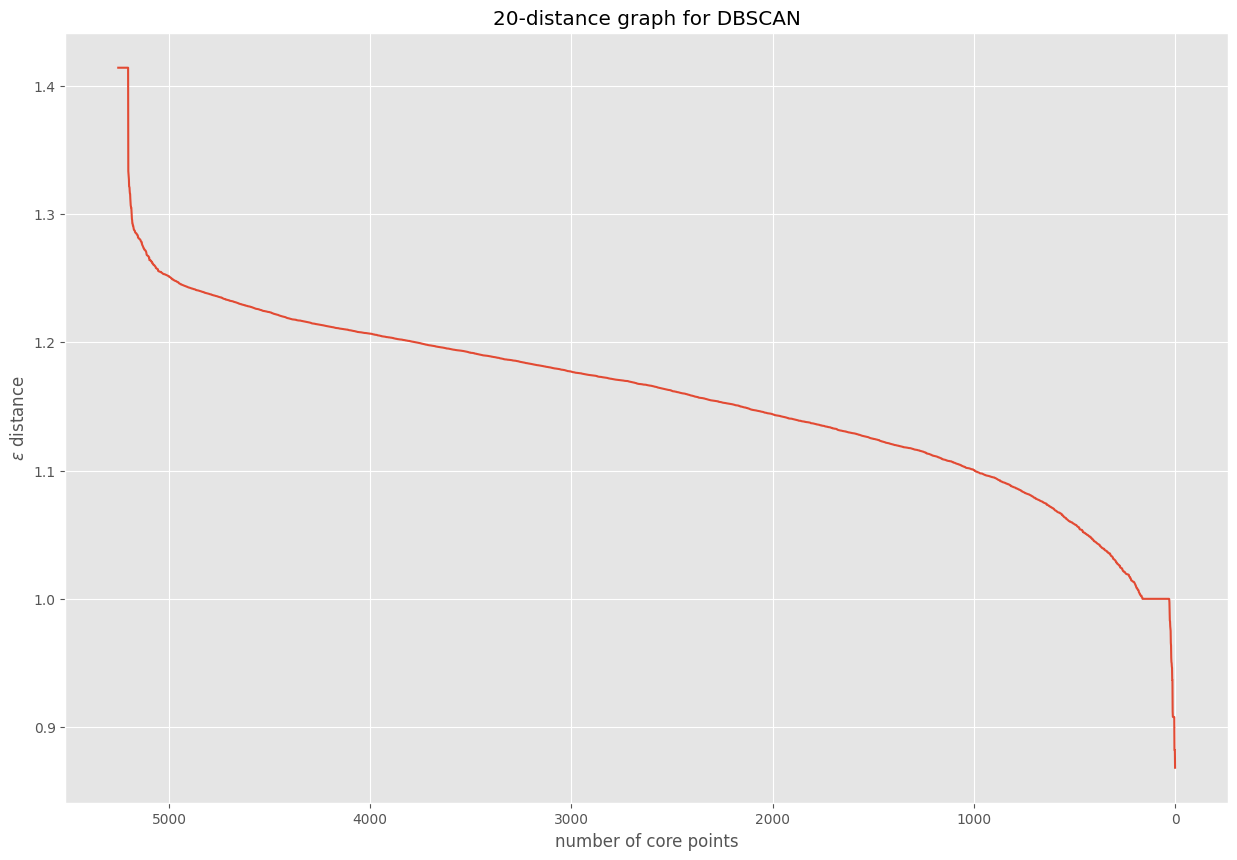

In [9]:
# TODO: write your function calls and code here
plot= plot_k_distance_graph(tf_idf_test, 20)

3.1:A good distance for the epsilon value in this data is 1.25 as shown by the bend on this graph. 
3.3: Epsilon values from 1.25-0.85 would result in a decrease in the distance threshold to the point that the majority of samples would be in the same cluster.
3.3:Epsilon values from 1.25-1.42 would result in most samples being noise or outliers as they are not part of any cluster 

### <a name="q4"></a> 4. Implement the function `plot_wcss_graph(dataset, k_range, **kwargs)` and call it with the train data title features and `k_range=range(3, 15)` then answer the following questions:<br> 4.1 Based on the plot, using the "elbow method" which numbers are suitable candidates as a good number of clusters? <br>4.2 Which number of clusters will minimize the WCSS? <br>4.3 What is the rational of the elbow method? Which number of clusters will minimize the WCSS?

MiniBatch used, number of clusters is:
3
MiniBatch used, number of clusters is:
4
MiniBatch used, number of clusters is:
5
MiniBatch used, number of clusters is:
6
MiniBatch used, number of clusters is:
7
MiniBatch used, number of clusters is:
8
MiniBatch used, number of clusters is:
9
MiniBatch used, number of clusters is:
10
MiniBatch used, number of clusters is:
11
MiniBatch used, number of clusters is:
12
MiniBatch used, number of clusters is:
13
MiniBatch used, number of clusters is:
14


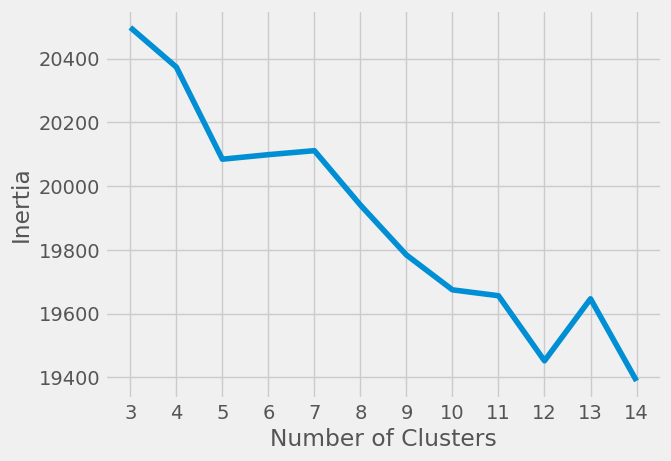

In [10]:
# TODO: write your function calls and code here
elbow= plot_wcss_graph(tf_idf_train,range(3, 15))#**kmean_kwargs

4.1: Based on the elbow graph a suitable number of clusters would be 10, as seen by the slight elbow. 
4.2: 14 clusters would minimise the WCSS, as K increases the WCSS decreases, this is because as we add more clusters, the within-cluster distances which is also inertia decrease. 
4.3: The elbow method plots various K values on a graph, the optimal value for K is where the graph begins to move parallel with the x-axis.

## Extrinsic clustering evaluation
### <a name="q5"></a> 5. Implement the function `plot_v_measure_graph(dataset, k_range, y_true)` and call it with the train data title features and `k_range=range(3, 15)` then answer the following questions:<br> 5.1 Based on the plot, which number of clusters yields the best result? <br>5.2 Compare the result of this extrinsic evaluation measure with the previous intrinsic evaluation results. What are the reasons choose one over the other?

MiniBatch used, number of clusters is:
3
MiniBatch used, number of clusters is:
4
MiniBatch used, number of clusters is:
5
MiniBatch used, number of clusters is:
6
MiniBatch used, number of clusters is:
7
MiniBatch used, number of clusters is:
8
MiniBatch used, number of clusters is:
9
MiniBatch used, number of clusters is:
10
MiniBatch used, number of clusters is:
11
MiniBatch used, number of clusters is:
12
MiniBatch used, number of clusters is:
13
MiniBatch used, number of clusters is:
14


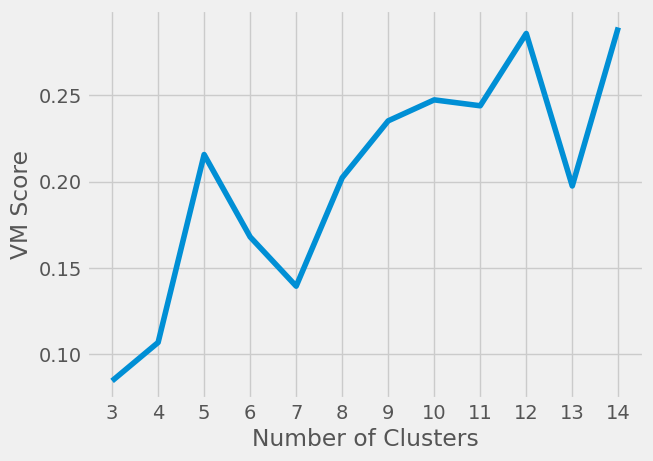

In [11]:
# TODO: write your function calls and code here
elbow=plot_v_measure_graph(tf_idf_train, train_df.Label, k_range=range(3, 15))

5.1:An optimal number of clusters based on this graph would be 10.
5.2:Similar to the intrinsic evaluation the optimal number of clusters when evalauting the VM score is also 10. The V-measure score looks at the tension between homogeneity of clusters and completeness, I would choose V-measure in this case as is grounded in the actual truth labels, and the inertia measurement is less robust in high dimensional space - which is exactly what is produced after tfidf vectorizaation of text.